In [23]:
from torch_geometric.data import Data
import torch_geometric.nn as gnn
import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
import torch_geometric
import networkx as nx
import pyvis
import matplotlib.pyplot as plt
import numpy as np

import srunner

from pathlib import Path
from typing import Protocol, cast
import enum
import dataclasses
import pickle
import random
import json
import uuid
import logging

In [24]:
logger = logging.getLogger("notebook")
logger.setLevel(logging.DEBUG)
logging.basicConfig(level=logging.DEBUG)
np.seterr(all='raise')
DEV = "cuda"
torch.set_float32_matmul_precision("medium")

writer = SummaryWriter()

@dataclasses.dataclass
class Counters:
    episodes: int = 0 
    epochs: int = 0
    runs: int = 0
    steps: int = 0
    batches: int = 0
    train_steps: int = 0

    def from_dict(self, d):
        for k, v in d.items():
            setattr(self, k, v)

COUNTERS = Counters()

In [25]:
from primitives import Clause

class NodeType(enum.Enum):
    VARIABLE = 0
    REDUNDANT = 1
    IRREDUNDANT = 2

class CnfGraph(Protocol):
    global_data: torch.Tensor
    x: torch.Tensor
    edge_index: torch.Tensor
    edge_attr: torch.Tensor
    node_type: torch.Tensor

@dataclasses.dataclass
class DimInfo:
    num_global_features: int
    num_var_features: int
    num_clause_features: int
    num_edge_features: int

@dataclasses.dataclass
class ReductionProblem:
    num_vars: int
    levels: list[int]
    vals: list[int]
    clauses: list[Clause]
    reducible_ids: list[int]
    conflicts: int

In [26]:
def problem_to_cnf_graph(problem: ReductionProblem) -> tuple[CnfGraph, DimInfo]:
    logger.info("Converting problem to CNF graph")
    num_vars = problem.num_vars

    fixed_vals = [problem.vals[i] if problem.levels[i] == 0 else 0 for i in range(num_vars)]

    clauses = []
    for clause in problem.clauses:
        new_lits = []
        for lit in clause.lits:
            v = abs(lit) - 1
            if fixed_vals[v] == 0:
                new_lits.append(lit)
            elif lit > 0 and fixed_vals[v] == 1 or lit < 0 and fixed_vals[v] == -1:
                break
            # else skip literal because it's falsified
        else:
            clauses.append(clause.with_lits(new_lits))

    num_clauses = len(clauses)
    num_free_vars = sum(1 for v in fixed_vals if v == 0)

    c_clause_sizes = np.array([len(clause.lits) for clause in clauses])
    c_clause_lbd = np.array([clause.lbd for clause in clauses])
    g_max_clause_size = c_clause_sizes.max()
    g_min_clause_size = c_clause_sizes.min()
    g_mean_clause_size = c_clause_sizes.mean()
    g_min_clause_lbd = c_clause_lbd.min()
    g_max_clause_lbd = c_clause_lbd.max()
    g_lbd_spread = g_max_clause_lbd - g_min_clause_lbd
    g_mean_clause_lbd = c_clause_lbd.mean()
    c_lbd_size_ratio = c_clause_lbd / c_clause_sizes
    c_num_pos_literals = np.array([sum(1 for lit in clause.lits if lit > 0) for clause in clauses])
    c_num_neg_literals = c_clause_sizes - c_num_pos_literals
    c_pos_neg_ratios = c_num_pos_literals / c_clause_sizes
    g_max_pos_neg_ratio = c_pos_neg_ratios.max()
    g_min_pos_neg_ratio = c_pos_neg_ratios.min()
    g_mean_pos_neg_ratio = c_pos_neg_ratios.mean()
    c_horn = c_num_pos_literals <= 1
    g_horn_ratio = c_horn.mean()
    c_inv_horn = c_num_neg_literals <= 1
    g_inv_horn_ratio = c_inv_horn.mean()
    g_size_spread = g_max_clause_size - g_min_clause_size
    g_pos_neg_ratio_spread = g_max_pos_neg_ratio - g_min_pos_neg_ratio
    c_conflicts_on_creation = np.array([clause.conflicts_on_creation for clause in clauses])
    c_time = c_conflicts_on_creation / problem.conflicts
    c_activity = np.array([clause.activity for clause in clauses], dtype=np.float32)
    c_activity /= max(c_activity.max(), 1.0)
    c_activity_top10 = c_activity > np.percentile(c_activity, 90)
    c_time_top10 = c_time > np.percentile(c_time, 90)
    c_times_reason = np.array([clause.times_reason for clause in clauses], dtype=np.float32)
    c_times_reason /= max(c_times_reason.max(), 1.0)
    c_times_reason_top10 = c_times_reason > np.percentile(c_times_reason, 90)


    v_pos = np.zeros(num_vars)
    v_neg = np.zeros(num_vars)
    v_horn = np.zeros(num_vars)
    v_invhorn = np.zeros(num_vars)

    for i, clause in enumerate(clauses):
        for lit in clause.lits:
            v = abs(lit) - 1
            if lit > 0:
                v_pos[v] += 1
            else:
                v_neg[v] += 1
            if c_horn[i]:
                v_horn[v] += 1
            if c_inv_horn[i]:
                v_invhorn[v] += 1

    v_count = v_pos + v_neg
    v_count_non_zero = np.maximum(v_count, 1)
    v_pos_neg_ratios = v_pos / v_count_non_zero
    v_horn_ratio = v_horn / v_count_non_zero
    v_invhorn_ratio = v_invhorn / v_count_non_zero
    g_var_horn_min = v_horn.min()
    g_var_horn_max = v_horn.max()
    g_var_horn_mean = v_horn.mean()
    g_var_invhorn_min = v_invhorn.min()
    g_var_invhorn_max = v_invhorn.max()
    g_var_invhorn_mean = v_invhorn.mean()
    g_var_horn_std = v_horn.std()
    g_var_invhorn_std = v_invhorn.std()
    g_var_pos_neg_ratio_std = v_pos_neg_ratios.std()
    g_var_count_std = v_count.std()
    g_var_clause_ratio = num_free_vars / num_clauses
    g_free_ratio = num_free_vars / num_vars

    c_clause_keep = np.array([clause.keep for clause in clauses])
    c_clause_redundant = np.array([clause.redundant for clause in clauses])

    global_features = [
        g_mean_clause_size,
        g_mean_clause_lbd,
        g_mean_pos_neg_ratio,
        g_horn_ratio,
        g_inv_horn_ratio,
        g_var_horn_mean,
        g_var_invhorn_mean,
        g_var_horn_std,
        g_var_invhorn_std,
        g_var_pos_neg_ratio_std,
        g_var_count_std,
        g_var_clause_ratio,
        g_free_ratio,
    ]

    clause_features = [
        c_clause_sizes,
        c_clause_sizes / num_vars,
        (c_clause_sizes - g_min_clause_size) / g_size_spread if g_size_spread > 0 else 0,
        c_clause_lbd,
        (c_clause_lbd - g_min_clause_lbd) / g_lbd_spread if g_lbd_spread > 0 else 0,
        c_lbd_size_ratio,
        c_pos_neg_ratios,
        c_horn,
        c_inv_horn,
        c_clause_redundant,
        c_clause_keep,
        c_time,
        c_time_top10,
        c_activity,
        c_activity_top10,
        c_times_reason,
        c_times_reason_top10,
    ]

    var_features = [
        v_pos,
        v_neg,
        v_pos_neg_ratios,
        v_horn,
        v_invhorn,
        v_horn_ratio,
        v_invhorn_ratio,
    ]

    embedding_size = max(len(var_features), len(clause_features))

    global_data = torch.tensor(global_features, dtype=torch.float32)
    x = torch.zeros(num_vars + num_clauses, embedding_size)
    edge_index = []
    edge_attr = []
    node_type = torch.zeros(num_vars + num_clauses, dtype=torch.int8)

    node_type[:num_vars] = NodeType.VARIABLE.value
    node_type[num_vars:] = NodeType.IRREDUNDANT.value

    reducible_ids = set(problem.reducible_ids)

    for i, clause in enumerate(clauses):
        if clause.id_ in reducible_ids:
            node_type[num_vars + i] = NodeType.REDUNDANT.value

    for i, f in enumerate(var_features):
        x[:num_vars, i] = torch.tensor(f, dtype=torch.float32)

    for i, f in enumerate(clause_features):
        x[num_vars:, i] = torch.tensor(f, dtype=torch.float32)

    for i, clause in enumerate(clauses):
        for lit in clause.lits:
            v = abs(lit) - 1
            edge_index.append((v, num_vars + i))
            edge_attr.append(-1 if lit < 0 else 1)

    edge_attr = torch.tensor(edge_attr, dtype=torch.float32).view(-1, 1)

    logger.info("Finished converting problem to CNF graph")

    return cast(CnfGraph, Data(
        global_data=global_data,
        x=x,
        edge_index=torch.tensor(edge_index, dtype=torch.int64).t(),
        edge_attr=edge_attr,
        node_type=node_type,
    )), DimInfo(
        num_clause_features=len(clause_features),
        num_edge_features=edge_attr.size(dim=1),
        num_global_features=len(global_features),
        num_var_features=len(var_features),
    )


def ordered_reducible_ids(problem: ReductionProblem) -> list[int]:
    reducible_ids = set(problem.reducible_ids)
    return [clause.id_ for clause in problem.clauses if clause.id_ in reducible_ids]

In [27]:
minimal_example_data, DIM_INFO = problem_to_cnf_graph(ReductionProblem(
    2,
    [1, 1],
    [0, 0],
    [
        Clause(0, [1, 2], 0, False, True, False),
        Clause(5, [-1, -2], 0, False, False, False),
        Clause(8, [-1, 2], 0, False, False, False),
    ],
    [5, 8],
    3,
))

print(DIM_INFO)

INFO:notebook:Converting problem to CNF graph
INFO:notebook:Finished converting problem to CNF graph


DimInfo(num_global_features=13, num_var_features=7, num_clause_features=17, num_edge_features=1)


INFO:notebook:Converting problem to CNF graph
INFO:notebook:Finished converting problem to CNF graph


<BarContainer object of 4 artists>

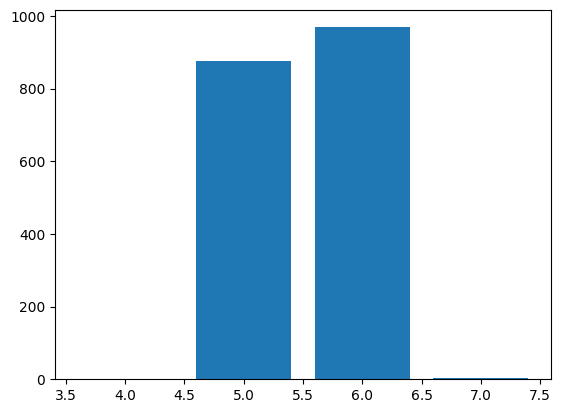

In [28]:
with open("../archives/example-problem.pkl", "rb") as f:
    problem = pickle.load(f)

example_data, _ = problem_to_cnf_graph(problem)

nx_graph = torch_geometric.utils.to_networkx(example_data, to_undirected=True)

g = pyvis.network.Network(width=1800, height=1000, cdn_resources='in_line')
g.toggle_hide_edges_on_drag = True
g.barnes_hut()
g.from_nx(nx_graph)
g.save_graph("example.html")

eccentricities = list(nx.eccentricity(nx_graph).values())
plt.bar(*np.unique(eccentricities, return_counts=True))

In [29]:
class CnfProcessingBlock(torch.nn.Module):
    def __init__(self, in_channels: int, out_channels: int, edge_dim: int, disambiguate_clauses: bool):
        super().__init__()

        self.disambiguate_clauses = disambiguate_clauses

        if disambiguate_clauses:
            self.conv_redundant = gnn.GATConv(in_channels, out_channels, edge_dim=edge_dim, residual=True)
            self.conv_irredundant = gnn.GATConv(in_channels, out_channels, edge_dim=edge_dim, residual=True)
        else:
            self.conv_clauses = gnn.GATConv(in_channels, out_channels, edge_dim=edge_dim, residual=True)

        self.conv_variables = gnn.GATConv(in_channels, out_channels, edge_dim=edge_dim, residual=True)

        self.activation = nn.ReLU(inplace=True)

    def forward(self, h, data):
        edge_index, edge_attr, node_type = data.edge_index, data.edge_attr, data.node_type

        out = torch.zeros_like(h)

        variable_mask = (node_type == NodeType.VARIABLE.value)
        out[variable_mask, :] = self.conv_variables(h, edge_index, edge_attr)[variable_mask, :]

        if self.disambiguate_clauses:
            redundant_mask = (node_type == NodeType.REDUNDANT.value)
            irredundant_mask = (node_type == NodeType.IRREDUNDANT.value)

            out[redundant_mask, :] = self.conv_redundant(h, edge_index, edge_attr)[redundant_mask, :]
            out[irredundant_mask, :] = self.conv_irredundant(h, edge_index, edge_attr)[irredundant_mask, :]
        else:
            clause_mask = (node_type != NodeType.VARIABLE.value)

            out[clause_mask] = self.conv_clauses(h, edge_index, edge_attr)[clause_mask, :]


        out = self.activation(out)

        return out

In [30]:
class ExpectedValueNormalization(torch.autograd.Function):
    @staticmethod
    def forward(ctx, p: torch.Tensor, ex: torch.Tensor):
        ex = torch.as_tensor(ex)

        gamma = torch.ones(p.shape[:-1], device=p.device)

        for _ in range(10):
            normalized = p ** gamma.unsqueeze(-1)
            f_gamma = normalized.sum(dim=-1) - ex
            f_prime_gamma = (normalized * p.log()).sum(dim=-1)
            new_gamma = gamma - f_gamma / f_prime_gamma
            gamma = torch.maximum(new_gamma, gamma / 10)

        normalized = p ** gamma.unsqueeze(-1)
        ctx.save_for_backward(p, normalized, gamma)
        return normalized

    @staticmethod
    def backward(ctx, grad_output):
        p, normalized, gamma = ctx.saved_tensors

        normalized_dp = normalized * p.log()
        denom = normalized_dp.sum(dim=-1)

        jac = (
            torch.diag_embed(gamma.unsqueeze(-1) * normalized / p) -
            (gamma / denom).unsqueeze(-1).unsqueeze(-1) * normalized_dp.unsqueeze(-2) * (normalized / p).unsqueeze(-1)
        )

        return (jac @ grad_output.unsqueeze(-1)).squeeze(-1), None


"""
x = torch.tensor([
    [1., 0.5, 0.5, 0.5, 0.1],
    [0.3, 0.5, 0.5, 0.8, 0.2],
], requires_grad=True)
optim = torch.optim.SGD([x], lr=0.1)
for _ in range(100):
    optim.zero_grad()
    y = ExpectedValueNormalization.apply(x, torch.tensor([2.0, 1.0]))
    loss = y.pow(3.0).sum()
    loss.backward()
    optim.step()
    print(x.sum(axis=1))
"""

'\nx = torch.tensor([\n    [1., 0.5, 0.5, 0.5, 0.1],\n    [0.3, 0.5, 0.5, 0.8, 0.2],\n], requires_grad=True)\noptim = torch.optim.SGD([x], lr=0.1)\nfor _ in range(100):\n    optim.zero_grad()\n    y = ExpectedValueNormalization.apply(x, torch.tensor([2.0, 1.0]))\n    loss = y.pow(3.0).sum()\n    loss.backward()\n    optim.step()\n    print(x.sum(axis=1))\n'

In [31]:
class ExpectedValueNormalizationLogits(torch.autograd.Function):
    @staticmethod
    def forward(ctx, logits: torch.Tensor, ex: torch.Tensor):
        ex = torch.as_tensor(ex)

        b = torch.zeros(logits.shape[:-1], device=logits.device)

        for _ in range(100):
            normalized = torch.sigmoid(logits + b.unsqueeze(-1))
            f_gamma = normalized.sum(dim=-1) - ex
            f_prime_gamma = (normalized * (1 - normalized)).sum(dim=-1)
            diff = torch.clamp(f_gamma / f_prime_gamma, -2, 2)
            if torch.all(diff.abs() < 1e-6):
                break
            b = b - diff

        normalized = torch.sigmoid(logits + b.unsqueeze(-1))
        ctx.save_for_backward(normalized)
        return normalized

    @staticmethod
    def backward(ctx, g):
        normalized, = ctx.saved_tensors
        p_grad = normalized * (1 - normalized)
        denom = p_grad.sum(dim=-1)
        coordwise = p_grad * g

        grad = coordwise - p_grad * coordwise.sum(axis=-1).unsqueeze(-1) / denom.unsqueeze(-1)

        return grad, None


probs = torch.tensor([
    [0.999, 0.5, 0.5, 0.5, 0.1],
    [0.3, 0.5, 0.5, 0.8, 0.2],
], requires_grad=True)
x = -(1 / probs - 1).log()
y = ExpectedValueNormalizationLogits.apply(x, torch.tensor([2.0, 1.0]))
# print(x, y, y.sum(axis=-1), sep="\n")
y.sum().backward()
# print(probs.grad)

optim = torch.optim.SGD([probs], lr=0.1)
for _ in range(100):
    optim.zero_grad()
    x = -(1 / probs - 1).log()
    y = ExpectedValueNormalizationLogits.apply(x, torch.tensor([2.0, 1.0]))
    loss = y.pow(3.0).sum()
    loss.backward()
    optim.step()
    # print(probs)

In [ ]:
class CnfGraphModel(nn.Module):
    def __init__(
        self,
        input_global_dim: int,
        input_variable_dim: int,
        input_clause_dim: int,
        hidden_dims: list[int],
        disambiguate_clauses_in_first: int = 2,
        edge_dim: int = 1,
    ):
        super().__init__()

        self.input_variable_dim = input_variable_dim
        self.input_clause_dim = input_clause_dim

        self.variable_fc = nn.Linear(input_global_dim + input_variable_dim, hidden_dims[0])
        self.clause_fc = nn.Linear(input_global_dim + input_clause_dim, hidden_dims[0])

        self.silu = nn.SiLU()

        self.processing_blocks = nn.ModuleList([
            CnfProcessingBlock(
                hidden_dims[i],
                hidden_dims[i + 1],
                edge_dim,
                i < disambiguate_clauses_in_first
            )
            for i in range(len(hidden_dims) - 1)
        ])

        self.output_fc = nn.Linear(hidden_dims[-1], 1, bias=False)

        self.value_fc_clauses = nn.Linear(hidden_dims[-1], 1, bias=False)
        self.value_fc_variables = nn.Linear(hidden_dims[-1], 1)

    def forward(self, cnf_graph: CnfGraph, ex: torch.Tensor | float):
        logger.info("Starting model forward pass")

        num_vertices = cnf_graph.x.shape[0]
        variable_mask = (cnf_graph.node_type == NodeType.VARIABLE.value)
        num_variables = variable_mask.sum()

        variable_input = torch.cat([
            cnf_graph.global_data.expand(num_variables, -1),
            cnf_graph.x[:num_variables, :self.input_variable_dim],
        ], dim=-1)

        variable_embedding = self.silu(self.variable_fc(variable_input))

        clause_input = torch.cat([
            cnf_graph.global_data.expand(num_vertices - num_variables, -1),
            cnf_graph.x[num_variables:, :self.input_clause_dim],
        ], dim=-1)

        clause_embedding = self.silu(self.clause_fc(clause_input))

        x = torch.cat([variable_embedding, clause_embedding], dim=0)

        for block in self.processing_blocks:
            x = block(x, cnf_graph)

        logits = self.output_fc(x[cnf_graph.node_type == NodeType.REDUNDANT.value]).view(-1)
        # logits = (logits - logits.mean()) / logits.std()
        # assert not torch.isnan(logits).any()
        # denorm_probs = torch.sigmoid(logits)
        # assert not torch.isnan(denorm_probs).any()
        # probs = ExpectedValueNormalization.apply(denorm_probs, ex)
        # if torch.isnan(probs).any():
        #     print(denorm_probs)
        #     print(probs)
        #     raise AssertionError()
        probs = ExpectedValueNormalizationLogits.apply(logits * HP.temperature, ex)
        if torch.isnan(probs).any():
            print(logits)
            print(probs)
            raise AssertionError()

        value_vars = self.value_fc_variables(x[variable_mask])
        value_clauses = self.value_fc_clauses(x[~variable_mask])
        value = torch.cat([value_vars, value_clauses]).mean()

        logger.info("Finished model forward pass")

        return probs, value

In [33]:
testing_model = CnfGraphModel(
    input_global_dim=DIM_INFO.num_global_features,
    input_variable_dim=DIM_INFO.num_var_features,
    input_clause_dim=DIM_INFO.num_clause_features,
    edge_dim=DIM_INFO.num_edge_features,
    hidden_dims=[32],
)

testing_model(minimal_example_data, 0.75)

INFO:notebook:Starting model forward pass
INFO:notebook:Finished model forward pass


(tensor([0.3699, 0.3801], grad_fn=<ExpectedValueNormalizationLogitsBackward>),
 tensor(0.0250, grad_fn=<MeanBackward0>))

In [ ]:
@dataclasses.dataclass
class Hyperparameters:
    batch_size: int = 64
    runs_per_episode: int = 64
    epochs: int = 10
    learning_rate: float = 2e-5
    eps_clip: float = 0.2
    entropy_coef: float = 0.01
    weight_decay: float = 1e-3
    value_weight: float = 0.5
    policy_weight: float = 1.0
    gae_gamma: float = 0.95
    gae_lambda: float = 0.8
    penalty_per_conflict: float = 5e-5
    temperature: float = 4.0


HP = Hyperparameters()


In [35]:
def compute_returns_advantages(rewards: list[float], values: list[float]) -> tuple[list[float], list[float]]:
    returns = []
    advantages = []
    gae = 0
    for i in reversed(range(len(rewards))):
        delta = rewards[i] + HP.gae_gamma * (values[i + 1] if i + 1 < len(values) else 0) - values[i]
        gae = delta + HP.gae_gamma * HP.gae_lambda * gae
        returns.append(gae + values[i])
        advantages.append(gae)
    return returns[::-1], advantages[::-1]

In [36]:
@dataclasses.dataclass
class EpisodeResult:
    states: list[CnfGraph]
    dists: list[torch.distributions.Bernoulli]
    actions: list[torch.Tensor]
    rewards: list[float]
    values: list[float]
    returns: list[float]
    advantages: list[float]

    stats: list[dict]

    @staticmethod
    def empty() -> 'EpisodeResult':
        return EpisodeResult([], [], [], [], [], [], [], [])

    def merge_with(self, other: 'EpisodeResult') -> 'EpisodeResult':
        assert (
            len(self.states) == len(self.dists) == len(self.actions) ==
            len(self.values) == len(self.rewards) == len(self.returns) ==
            len(self.advantages)
        )
        assert (
            len(other.states) == len(other.dists) == len(other.actions) ==
            len(other.values) == len(other.rewards) == len(other.returns) ==
            len(other.advantages)
        )
        return EpisodeResult(
            self.states + other.states,
            self.dists + other.dists,
            self.actions + other.actions,
            self.rewards + other.rewards,
            self.values + other.values,
            self.returns + other.returns,
            self.advantages + other.advantages,
            self.stats + other.stats,
        )

    @staticmethod
    def merge_all(results: list['EpisodeResult']) -> 'EpisodeResult':
        result = results[0]
        for other in results[1:]:
            result = result.merge_with(other)
        return result

    def add(self, *, state, dist, action, reward, value):
        assert (
            len(self.states) == len(self.dists) == len(self.actions) ==
            len(self.values) == len(self.rewards)
        )
        self.states.append(state)
        self.dists.append(dist)
        self.actions.append(action)
        if reward is not None:
            self.rewards.append(reward)
        self.values.append(value)

    def add_reward(self, reward):
        assert (
            len(self.states) == len(self.dists) == len(self.actions) ==
            len(self.values) == len(self.rewards) + 1
        )
        self.rewards.append(reward)

    def complete(self, stats: dict):
        assert (
            len(self.states) == len(self.dists) == len(self.actions) ==
            len(self.values) == len(self.rewards)
        )
        assert len(self.stats) == 0
        self.returns, self.advantages = compute_returns_advantages(self.rewards, self.values)
        self.stats = [stats]


In [37]:
class Agent:
    def __init__(self, model):
        self.model = model.to(DEV)
        self.optim = torch.optim.AdamW(
            self.model.parameters(),
            lr=HP.learning_rate,
            weight_decay=HP.weight_decay
        )

    def act(self, cnf_graph: CnfGraph, ex: float):
        COUNTERS.steps += 1
        logger.info("Running agent act")
        with torch.no_grad():
            cnf_graph = cnf_graph.to(DEV)
            assert torch.isnan(cnf_graph.x).sum() == 0
            assert torch.isnan(cnf_graph.edge_attr).sum() == 0
            assert torch.isnan(cnf_graph.global_data).sum() == 0
            probs, value = self.model(cnf_graph, ex)
            logger.info("Finished agent act")
            return torch.distributions.Bernoulli(probs), value.item()

    def update(self, results: EpisodeResult, silent: bool = False):
        logger.info("Training agent")
        r = results

        n = len(r.states)
        batch_size = HP.batch_size
        advantages = torch.tensor(r.advantages, dtype=torch.float32)
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

        for num_epoch in range(HP.epochs):
            COUNTERS.epochs += 1
            logger.info("Training agent, epoch %d", num_epoch)
            indices = random.sample(range(n), n)
            for batch_start in range(0, n, batch_size):
                COUNTERS.batches += 1
                idx = indices[batch_start:batch_start + batch_size]

                self.optim.zero_grad()
                for i in idx:
                    COUNTERS.train_steps += 1
                    graph, ex = r.states[i]
                    new_probs, value = self.model(graph, ex)
                    value = value.cpu()
                    dist = torch.distributions.Bernoulli(probs=new_probs)
                    log_probs = dist.log_prob(r.actions[i].float())
                    entropy = dist.entropy().mean()

                    ratio = torch.exp(log_probs - r.dists[i].log_prob(r.actions[i].float()))
                    surr1 = ratio * advantages[i]
                    surr2 = torch.clamp(ratio, 1.0 - HP.eps_clip, 1.0 + HP.eps_clip) * advantages[i]

                    value_loss = torch.nn.functional.huber_loss(value, torch.tensor(r.returns[i]))
                    policy_loss = -torch.min(surr1, surr2).mean()

                    if not silent:
                        writer.add_scalar("value loss", value_loss.item(), COUNTERS.train_steps)

                    loss = (
                        HP.policy_weight * policy_loss
                        + HP.value_weight * value_loss
                        - HP.entropy_coef * entropy
                    ) / len(idx)

                    loss.backward()

                self.optim.step()

In [38]:
testing_agent = Agent(testing_model)

states = [
    (minimal_example_data, 0.75),
    (minimal_example_data, 0.5),
    (minimal_example_data, 0.25),
]

dist1, value1 = testing_agent.act(*states[0])
dist2, value2 = testing_agent.act(*states[1])
dist3, value3 = testing_agent.act(*states[2])

dists = [dist1, dist2, dist3]
values = [value1, value2, value3]
print(values)

actions = [dist.sample() > 0.5 for dist in dists]
rewards = [-1.0, -1.0, 10.0]

returns, advantages = compute_returns_advantages(rewards, [1.0, 1.0, 1.0])
print(advantages)

results = EpisodeResult(
    states,
    dists,
    actions,
    rewards,
    values,
    returns,
    advantages,
    [],
)

testing_agent.update(results, silent=True)


INFO:notebook:Running agent act
INFO:notebook:Starting model forward pass
INFO:notebook:Finished model forward pass
INFO:notebook:Finished agent act
INFO:notebook:Running agent act
INFO:notebook:Starting model forward pass
INFO:notebook:Finished model forward pass
INFO:notebook:Finished agent act
INFO:notebook:Running agent act
INFO:notebook:Starting model forward pass
INFO:notebook:Finished model forward pass
INFO:notebook:Finished agent act
INFO:notebook:Training agent
INFO:notebook:Training agent, epoch 0
INFO:notebook:Starting model forward pass
INFO:notebook:Finished model forward pass
INFO:notebook:Starting model forward pass
INFO:notebook:Finished model forward pass
INFO:notebook:Starting model forward pass
INFO:notebook:Finished model forward pass
INFO:notebook:Training agent, epoch 1
INFO:notebook:Starting model forward pass
INFO:notebook:Finished model forward pass
INFO:notebook:Starting model forward pass
INFO:notebook:Finished model forward pass
INFO:notebook:Starting model

[0.025018393993377686, 0.025018393993377686, 0.025018393993377686]
[3.3504000000000005, 5.79, 9.0]


In [39]:
@dataclasses.dataclass
class CnfProblemInstance:
    result: bool
    path: Path
    stats: dict[str, any]
    stats_no_reductions: dict[str, any]


with open("../archives/runs.json", "r") as f:
    runs = [json.loads(line) for line in f.readlines()]
    runs = [CnfProblemInstance(
        result=run["result"],
        path=Path(run["path"]),
        stats=run["stats"],
        stats_no_reductions=run["stats_no_reductions"],
    ) for run in runs]


def get_random_instance(unsat_only: bool = True) -> CnfProblemInstance:
    while True:
        run = random.choice(runs)
        if not unsat_only or not run.result:
            return run

In [40]:
class CadicalEnv:
    def __init__(
        self,
        cadical_path: Path,
        runs_per_episode: int = 16,
    ):
        self.cadical_path = cadical_path
        self.runs_per_episode = runs_per_episode

    def run_instance(self, agent: Agent, instance: CnfProblemInstance) -> EpisodeResult:
        COUNTERS.runs += 1
        result = EpisodeResult.empty()
        router = srunner.Router()

        reduce_number = 0
        last_conflicts = 0

        @router.route("reduce")
        def _reduce_route(conn: srunner.Connection, info: srunner.RunInfo, _data):
            nonlocal reduce_number
            nonlocal last_conflicts

            logger.info("Received clause database reduction")

            num_vars = conn.read_u64()
            levels = [-1] * num_vars
            vals = [-1] * num_vars
            for i in range(num_vars):
                vals[i] = conn.read_i8()
                levels[i] = conn.read_i32()
            num_clauses = conn.read_u64()
            clauses = [conn.read_clause() for _ in range(num_clauses)]
            num_reducible = conn.read_u64()
            num_target = conn.read_u64()
            reducible_ids = [conn.read_u64() for _ in range(num_reducible)]
            conflicts = conn.read_u64()
            conn.write_ok()

            if reduce_number != 0:
                result.add_reward(-(conflicts - last_conflicts) * HP.penalty_per_conflict)
            last_conflicts = conflicts

            problem = ReductionProblem(
                num_vars=num_vars,
                levels=levels,
                vals=vals,
                clauses=clauses,
                reducible_ids=reducible_ids,
                conflicts=conflicts,
            )

            logger.debug("Finished reading reduction data")

            cnf, dim_info = problem_to_cnf_graph(problem)
            assert dim_info == DIM_INFO

            ex = float(num_target)

            logger.debug("Converted problem to CNF graph")

            dist, value = agent.act(cnf, ex)
            print(dist.probs)
            action = dist.sample()

            logger.debug("Agent acted")

            result.add(
                state=(cnf, ex),
                dist=dist,
                action=action,
                reward=None,
                value=value,
            )

            logger.debug("Results are written to replay buffer")

            reducible_ids = ordered_reducible_ids(problem)

            to_reduces = []
            for id_, a in zip(reducible_ids, action):
                if a > 0.5:
                    to_reduces.append(id_)

            logger.debug("Sending reduction data")

            conn.write_u32(len(to_reduces))
            for id_ in to_reduces:
                conn.write_u64(id_)

            reduce_number += 1

        @router.route("stats")
        def _stats_route(conn: srunner.Connection, info: srunner.RunInfo, data):
            nonlocal last_conflicts

            logger.info("Received stats")
            stats = {}
            while (name := conn.read_str()) != "end":
                if name == "time":
                    stats[name] = conn.read_f64()
                else:
                    stats[name] = conn.read_u64()
            conn.write_ok()

            for name, value in stats.items():
                writer.add_scalar(f"Runs/{name}", value, COUNTERS.runs)
                if instance.stats[name]:
                    writer.add_scalar(f"Runs relative/{name}", value / instance.stats[name], COUNTERS.runs)

            writer.add_scalar(f"run_conflicts", stats["conflicts"], COUNTERS.runs)
            writer.add_scalar(f"relative_lbd_conflicts", stats["conflicts"] / instance.stats["conflicts"], COUNTERS.runs)
            writer.add_scalar(f"relative_random_conflicts", stats["conflicts"] / instance.stats_no_reductions["conflicts"], COUNTERS.runs)

            result.add_reward(-(stats["conflicts"] - last_conflicts) * HP.penalty_per_conflict)
            result.complete(stats)

        srunner.run_instance(
            self.cadical_path,
            ["--reduce-mode", "2"],
            instance.path,
            router.routes,
            silent=True,
        )

        return result

    def run_episode(self, agent: Agent) -> EpisodeResult:
        results = []
        for _ in range(self.runs_per_episode):
            instance = get_random_instance()
            results.append(self.run_instance(agent, instance))

        return EpisodeResult.merge_all(results)


In [41]:
logging.basicConfig(level=logging.WARNING)
logger.setLevel(logging.WARNING)

model = CnfGraphModel(
    input_global_dim=DIM_INFO.num_global_features,
    input_variable_dim=DIM_INFO.num_var_features,
    input_clause_dim=DIM_INFO.num_clause_features,
    edge_dim=DIM_INFO.num_edge_features,
    hidden_dims=[32],
)

agent = Agent(model)

env = CadicalEnv(
    Path("../cadical/build/cadical"),
    runs_per_episode=HP.runs_per_episode,
)

In [ ]:
CHECKPOINT_ROOT = Path("../checkpoints-shallow")
CHECKPOINT_ROOT.mkdir(exist_ok=True, parents=True)
saved_checkpoints = list(CHECKPOINT_ROOT.glob("*.pt"))
saved_checkpoints.sort(key=lambda p: p.stat().st_mtime)

if len(saved_checkpoints) > 0:
    checkpoint = torch.load(saved_checkpoints[-1])
    agent.model.load_state_dict(checkpoint["model"])
    agent.optim.load_state_dict(checkpoint["optim"])
    COUNTERS.from_dict(checkpoint["counters"])

/tmp/ipykernel_31435/3183735522.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(saved_checkpoints[-1])


In [43]:
# torch.cuda.memory._record_memory_history(max_entries=10 ** 7)

In [44]:
while True:
    COUNTERS.episodes += 1
    print(f"Episode {COUNTERS.episodes}")
    writer.add_scalar("episode", COUNTERS.episodes, COUNTERS.episodes)
    results = env.run_episode(agent)
    logger.info("Finished episode, starting training")
    agent.update(results)

    torch.save({
        "model": agent.model.state_dict(),
        "optim": agent.optim.state_dict(),
        "counters": dataclasses.asdict(COUNTERS),
    }, f"../checkpoints-shallow/agent-{COUNTERS.episodes}-{uuid.uuid4()}.pt")

    writer.add_scalar("episode_reward", sum(results.rewards), COUNTERS.episodes)
    print(f"Rewards: {sum(results.rewards)}")
    del results


INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-fb82a721-4941-41d4-a20c-bba9ad0a8aaa.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/89f35a7e-ecc6-45e1-9d0d-e7391a2c6bb9.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-fb82a721-4941-41d4-a20c-bba9ad0a8aaa.cnf
DEBUG:srunner:Starting connection to /tmp/89f35a7e-ecc6-45e1-9d0d-e7391a2c6bb9.sock


Episode 1
tensor([0.7271, 0.7613, 0.7455, 0.6876, 0.7347, 0.7190, 0.7505, 0.7464, 0.7025,
        0.7358, 0.7057, 0.7611, 0.7585, 0.7263, 0.7435, 0.7461, 0.7600, 0.7775,
        0.7669, 0.7166, 0.6758, 0.7537, 0.7547, 0.7063, 0.7557, 0.7515, 0.7366,
        0.7086, 0.7092, 0.7175, 0.7346, 0.7311, 0.7443, 0.7431, 0.7523, 0.7628,
        0.7546, 0.8003, 0.7807, 0.6830, 0.7713, 0.7488, 0.7932, 0.6957, 0.7122,
        0.7015, 0.7503, 0.7614, 0.7781, 0.7722, 0.7250, 0.7300, 0.7300, 0.8040,
        0.7835, 0.7694, 0.7249, 0.7931, 0.7089, 0.7186, 0.6966, 0.7192, 0.7398,
        0.7511, 0.7289, 0.7342, 0.7338, 0.7444, 0.7823, 0.7423, 0.7619, 0.7604,
        0.7058, 0.7409, 0.7709, 0.7341, 0.7191, 0.7565, 0.7491, 0.7597, 0.7935,
        0.7658, 0.7581, 0.7446, 0.7511, 0.7304, 0.7510, 0.7047, 0.8332, 0.7605,
        0.7448, 0.7640, 0.7651, 0.7340, 0.7851, 0.7771, 0.7568, 0.7611, 0.7661,
        0.7708, 0.7161, 0.7739, 0.7529, 0.7882, 0.7436, 0.7591, 0.7338, 0.7174,
        0.7276, 0.7836, 0.7611

INFO:srunner:Running ../cadical/build/cadical on /home/elt/projects/sat-rl-exploration/instances/unif-76755b06-0ccd-444c-9c89-ff98940a2b64.cnf
INFO:srunner:Running /home/elt/projects/sat-rl-exploration/py/../cadical/build/cadical --reduce-mode 2 --socket /tmp/3a9ffe83-0025-4b74-92e0-445b40d7f51e.sock -t 1000000000 /home/elt/projects/sat-rl-exploration/instances/unif-76755b06-0ccd-444c-9c89-ff98940a2b64.cnf
DEBUG:srunner:Starting connection to /tmp/3a9ffe83-0025-4b74-92e0-445b40d7f51e.sock


tensor([0.7272, 0.7294, 0.7466, 0.7327, 0.6862, 0.6704, 0.7490, 0.7260, 0.6852,
        0.6834, 0.6861, 0.6826, 0.7103, 0.7270, 0.7437, 0.6834, 0.7242, 0.7423,
        0.7497, 0.7146, 0.7286, 0.7110, 0.7250, 0.7308, 0.7310, 0.7036, 0.7552,
        0.7490, 0.7589, 0.7588, 0.7448, 0.7154, 0.7071, 0.7389, 0.7536, 0.7670,
        0.7566, 0.7439, 0.7803, 0.7736, 0.7361, 0.8059, 0.7238, 0.7496, 0.7357,
        0.7553, 0.7685, 0.7229, 0.7412, 0.8301, 0.7535, 0.7286, 0.7348, 0.7741,
        0.7541, 0.7777, 0.7634, 0.7748, 0.7551, 0.7355, 0.7452, 0.7726, 0.7783,
        0.7594, 0.7266, 0.7921, 0.7679, 0.8062, 0.7421, 0.7359, 0.7619, 0.7698,
        0.7435, 0.8255, 0.7398, 0.7466, 0.7703, 0.7939, 0.7799, 0.7554, 0.7520,
        0.7601, 0.7697, 0.7946, 0.7792, 0.7549, 0.7584, 0.7224, 0.7056, 0.7323,
        0.7336, 0.7324, 0.7056, 0.7074, 0.7517, 0.7184, 0.7596, 0.7342, 0.7649,
        0.7175, 0.7255, 0.7098, 0.7865, 0.7714, 0.7737, 0.7811, 0.7102, 0.7701,
        0.7956, 0.7997, 0.7531, 0.7779, 

KeyboardInterrupt: 

In [ ]:
torch.cuda.memory._dump_snapshot(f"memory.pickle")

# Stop recording memory snapshot history.
torch.cuda.memory._record_memory_history(enabled=None)